In [2]:
#Importação de bibliotecas
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openslide #para carregar os ficheiros .svs
import random
import os
from PIL import Image
from tqdm import tqdm  # barra de progresso
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc as calc_auc, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from skimage.transform import resize
from tensorflow.keras.applications import ResNet50, resnet50, EfficientNetB0
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,  GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau)
from tensorflow.keras.applications.resnet50 import preprocess_input




2025-06-12 21:43:10.208206: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Caminho para o dataset
base_dir = "/Users/lauracarreira/Desktop/Universidade de Aveiro/4º ano/2º semestre/archive"  # ← Corrigido!

# Parâmetros
patch_size = 50
max_patches_per_class = 2000  # máximo por classe
data = []
counts_per_class = defaultdict(int)

# Debug: verificar se o diretório existe e listar arquivos
if not os.path.exists(base_dir):
    raise ValueError(f"[ERRO] O diretório base_dir não existe: {base_dir}")

print(f"[DEBUG] Procurando imagens em: {base_dir}")

total_png = 0
for root, dirs, files in os.walk(base_dir):
    for filename in files:
        if filename.lower().endswith(".png"):
            total_png += 1
            # Tentar extrair o label do nome do arquivo
            try:
                # Procura por "_classX" ou "_0"/"_1" no nome
                if "_class" in filename:
                    label = int(filename.split("_class")[1].split(".")[0])
                else:
                    label = int(filename.split("_")[1])
            except Exception as e:
                print(f"[ERRO] Não foi possível extrair label de {filename}: {e}")
                continue

            if counts_per_class[label] >= max_patches_per_class:
                continue

            file_path = os.path.join(root, filename)
            try:
                img = Image.open(file_path).convert("RGB")
                img_array = np.array(img) / 255.0  # normalizar para [0, 1]
                if img_array.shape != (50, 50, 3):
                    print(f"[AVISO] {filename} tem shape {img_array.shape}, esperado (50, 50, 3)")
                    continue

                data.append((img_array, label))
                counts_per_class[label] += 1
            except Exception as e:
                print(f"[ERRO] {filename}: {e}")

print(f"[DEBUG] Total de arquivos PNG encontrados: {total_png}")

# Mostrar distribuição
print("\n[INFO] Patches recolhidos por classe:")
for k, v in counts_per_class.items():
    print(f"Classe {k}: {v}")

# Separar imagens e labels
X = np.array([img for img, _ in data])
y = np.array([lbl for _, lbl in data])

# Checar se algum dado foi carregado
if X.size == 0 or y.size == 0:
    print("[ERRO] Nenhuma imagem encontrada em 'data'.")
    print("Verifique se:")
    print("- O caminho base_dir está correto.")
    print("- Existem arquivos PNG no diretório.")
    print("- Os arquivos têm o formato de nome esperado (ex: *_class0.png ou *_0.png).")
    print("- As imagens têm shape (50, 50, 3).")
    raise ValueError("[ERRO] Nenhuma imagem encontrada em 'data'. Verifique o caminho do dataset e o critério de filtragem. O processamento será interrompido.")
else:
    # Redimensionar para 224x224 para ResNet
    X_resized = tf.image.resize(X, (224, 224))
    # Preprocessar para ResNet50
    X_preprocessed = preprocess_input(X_resized * 255.0)

    # Carregar modelo
    print("[INFO] A extrair features com ResNet50...")
    base_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
    model = Model(inputs=base_model.input, outputs=base_model.output)

    # Extrair features
    X_features = model.predict(X_preprocessed, verbose=1)
    print(f"[INFO] Features extraídas: {X_features.shape}")

[DEBUG] Procurando imagens em: /Users/lauracarreira/Desktop/Universidade de Aveiro/4º ano/2º semestre/archive
[AVISO] 9036_idx5_x1601_y2851_class0.png tem shape (30, 50, 3), esperado (50, 50, 3)
[AVISO] 9036_idx5_x701_y2851_class0.png tem shape (30, 50, 3), esperado (50, 50, 3)
[AVISO] 9036_idx5_x2651_y2851_class0.png tem shape (30, 50, 3), esperado (50, 50, 3)
[AVISO] 9036_idx5_x1651_y2851_class0.png tem shape (30, 50, 3), esperado (50, 50, 3)
[AVISO] 9036_idx5_x751_y2851_class0.png tem shape (30, 50, 3), esperado (50, 50, 3)
[AVISO] 9036_idx5_x2601_y2851_class0.png tem shape (30, 50, 3), esperado (50, 50, 3)
[AVISO] 9036_idx5_x2501_y2851_class0.png tem shape (30, 50, 3), esperado (50, 50, 3)
[AVISO] 9036_idx5_x2801_y2851_class0.png tem shape (30, 50, 3), esperado (50, 50, 3)
[AVISO] 9036_idx5_x1851_y2851_class0.png tem shape (30, 50, 3), esperado (50, 50, 3)
[AVISO] 9036_idx5_x1551_y2851_class0.png tem shape (30, 50, 3), esperado (50, 50, 3)
[AVISO] 9036_idx5_x451_y2851_class0.png te

[INFO] A redimensionar patches para 64x64...
[INFO] A aplicar PCA para manter 95% da variância...
[INFO] Número de componentes selecionados: 797


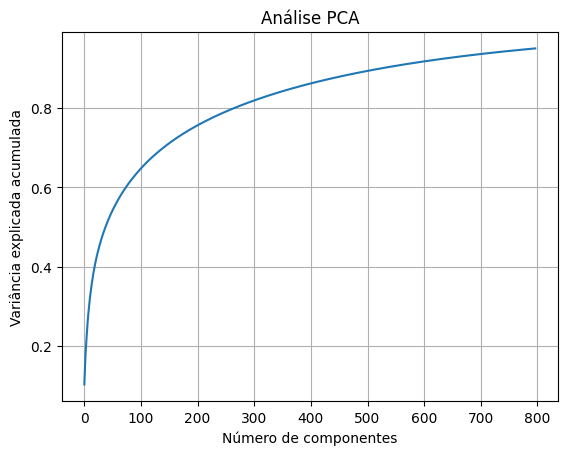

[INFO] A iniciar GridSearchCV para SVM...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END ................................C=0.01, gamma=scale; total time=  42.1s
[CV] END .................................C=0.01, gamma=auto; total time=  42.4s
[CV] END ................................C=0.01, gamma=scale; total time=  42.5s
[CV] END ................................C=0.01, gamma=scale; total time=  42.6s
[CV] END .................................C=0.01, gamma=auto; total time=  41.8s
[CV] END .................................C=0.01, gamma=auto; total time=  42.7s
[CV] END .................................C=0.01, gamma=0.01; total time=  42.3s
[CV] END .................................C=0.01, gamma=0.01; total time=  42.6s
[CV] END .................................C=0.01, gamma=0.01; total time=  48.7s
[CV] END ..................................C=0.01, gamma=0.1; total time=  49.2s
[CV] END ..................................C=0.01, gamma=0.1; total time=  49.1s
[CV] E

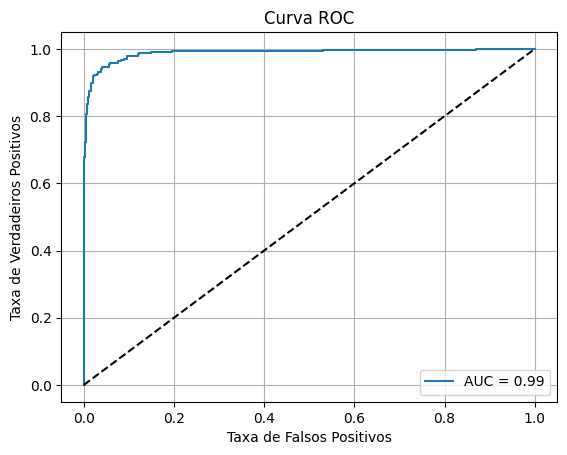

In [4]:
# Redimensionar para 64x64
print("[INFO] A redimensionar patches para 64x64...")
X_resized = np.array([resize(img, (64, 64), anti_aliasing=True) for img in X])

# Flatten das imagens
X_flat = X_features

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# PCA para reduzir dimensão
print("[INFO] A aplicar PCA para manter 95% da variância...")
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"[INFO] Número de componentes selecionados: {pca.n_components_}")

# Visualizar variância explicada acumulada
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada acumulada')
plt.title('Análise PCA')
plt.grid(True)
plt.show()

# Definir e ajustar SVM com calibragem e GridSearchCV
print("[INFO] A iniciar GridSearchCV para SVM...")
svm = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]
}

grid = GridSearchCV(svm, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)
grid.fit(X_train_pca, y_train)
print(f"[INFO] Melhores parâmetros encontrados: {grid.best_params_}")

# Calibrar o melhor modelo encontrado
best_svm = grid.best_estimator_
calibrated_svm = CalibratedClassifierCV(best_svm, cv=5)
calibrated_svm.fit(X_train_pca, y_train)

# Prever probabilidades com modelo calibrado
y_scores = calibrated_svm.predict_proba(X_test_pca)[:, 1]
y_pred = calibrated_svm.predict(X_test_pca)

# Avaliar o modelo
print("[INFO] Métricas de avaliação:")
print(classification_report(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# Plotar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = calc_auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

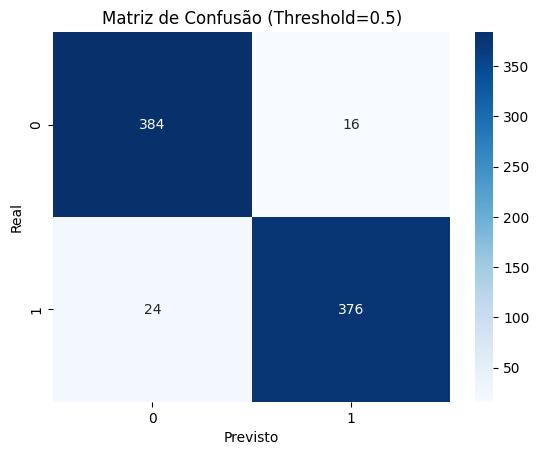

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       400
           1       0.96      0.94      0.95       400

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800

AUC: 0.988


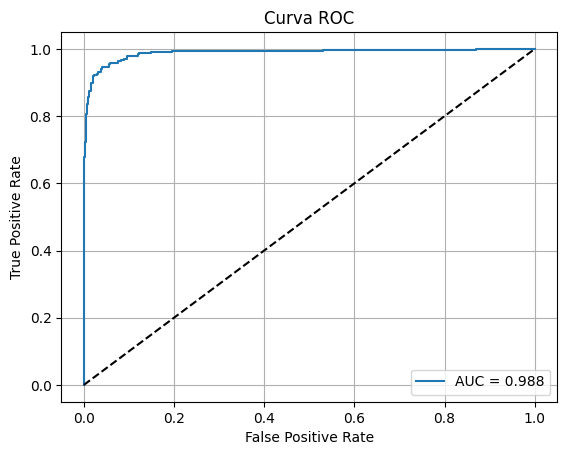

In [5]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão (Threshold=0.5)")
plt.show()

# Relatório de classificação e AUC
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_scores)
print(f"AUC: {auc:.3f}")

# Plot da Curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')  # linha diagonal base
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()




In [ ]:
NN

Iteration 1, loss = 1.30680827
Iteration 2, loss = 0.43757047
Iteration 3, loss = 0.26352138
Iteration 4, loss = 0.20800088
Iteration 5, loss = 0.18184992
Iteration 6, loss = 0.16360074
Iteration 7, loss = 0.14905601
Iteration 8, loss = 0.13738189
Iteration 9, loss = 0.12721738
Iteration 10, loss = 0.11886933
Iteration 11, loss = 0.11035090
Iteration 12, loss = 0.10353748
Iteration 13, loss = 0.09680465
Iteration 14, loss = 0.09121328
Iteration 15, loss = 0.08605254
Iteration 16, loss = 0.08108179
Iteration 17, loss = 0.07682730
Iteration 18, loss = 0.07296165
Iteration 19, loss = 0.06933534
Iteration 20, loss = 0.06571565
Iteration 21, loss = 0.06233936
Iteration 22, loss = 0.05974013
Iteration 23, loss = 0.05691690
Iteration 24, loss = 0.05434400
Iteration 25, loss = 0.05166389
Iteration 26, loss = 0.04938814
Iteration 27, loss = 0.04722576
Iteration 28, loss = 0.04548826
Iteration 29, loss = 0.04312108
Iteration 30, loss = 0.04153728
Iteration 31, loss = 0.03952209
Iteration 32, los

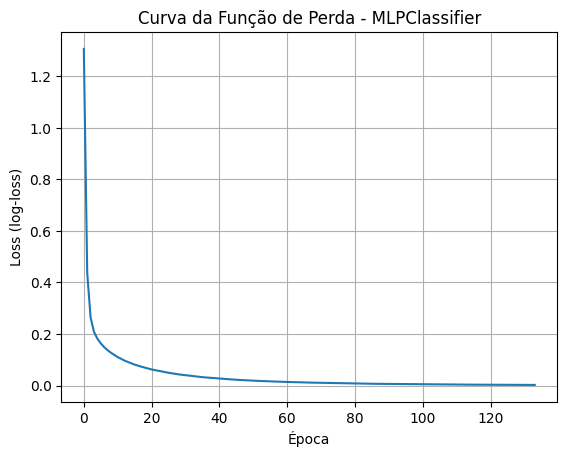

In [9]:
# Normalizar os dados antes do PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar PCA (ex: 50 componentes)
pca = PCA(n_components=70)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

#Criar o classificador MLP
mlp = MLPClassifier(max_iter=2000, random_state=42)

# Definir o grid de hiperparâmetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (10, 10)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam'],
    'learning_rate': ['constant']
}

# Pesquisa em grelha com validação cruzada (5-fold)
grid_search = GridSearchCV(mlp, param_grid, cv=5)

mlp = MLPClassifier(
    hidden_layer_sizes=(100,), 
    activation='relu',
    solver='adam',
    learning_rate='constant',
    max_iter=2000,
    random_state=42,
    verbose=True  # Mostra a loss no terminal
)
mlp.fit(X_train_pca, y_train)

plt.plot(mlp.loss_curve_)
plt.xlabel("Época")
plt.ylabel("Loss (log-loss)")
plt.title("Curva da Função de Perda - MLPClassifier")
plt.grid(True)
plt.show()

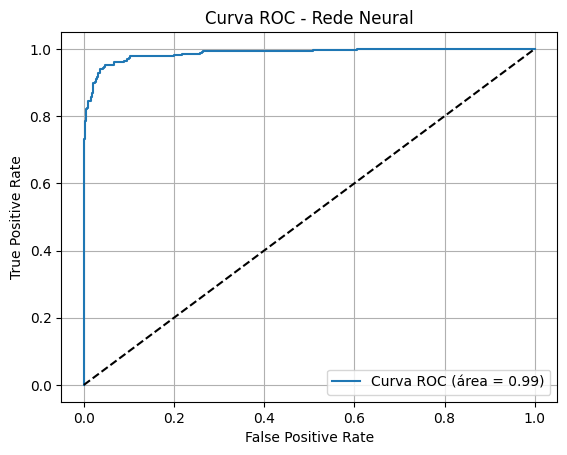

               precision    recall  f1-score   support

Sem Metástase       0.95      0.94      0.95       400
Com Metástase       0.94      0.95      0.95       400

     accuracy                           0.95       800
    macro avg       0.95      0.95      0.95       800
 weighted avg       0.95      0.95      0.95       800



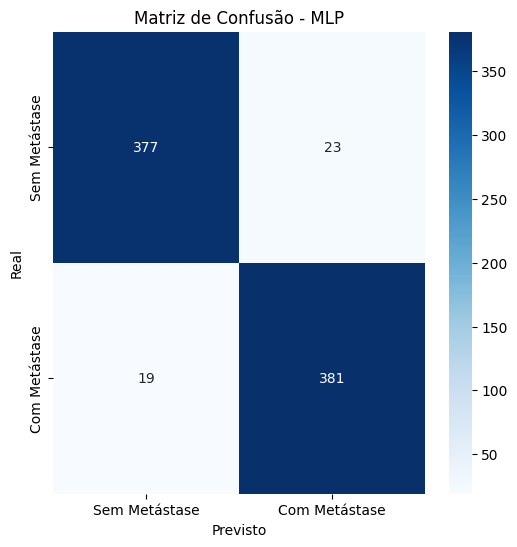

In [10]:
# Ajustar o GridSearchCV antes de acessar os resultados
grid_search.fit(X_train_pca, y_train)

# Resultados
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

# Previsões no teste
y_pred = best_model.predict(X_test_pca)
y_prob = best_model.predict_proba(X_test_pca)[:, 1]

# Etapa 6: Relatório e matriz

report = classification_report(y_test, y_pred, target_names=["Sem Metástase", "Com Metástase"])
matrix = confusion_matrix(y_test, y_pred)

# Probabilidades da classe positiva (metástase)
y_prob = best_model.predict_proba(X_test_pca)[:, 1]

# Calcular curva ROC e AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = calc_auc(fpr, tpr)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # linha diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Rede Neural')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Gerar matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Imprimir relatório de classificação
print(classification_report(y_test, y_pred, target_names=["Sem Metástase", "Com Metástase"]))

# Plotar a matriz de confusão
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Sem Metástase", "Com Metástase"],
            yticklabels=["Sem Metástase", "Com Metástase"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - MLP")
plt.show()